In [113]:
# Import relevant libraries
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import aiscm_helper as scmhelper
from ydata_profiling import ProfileReport
import missingno as msno
import pivottablejs as pvt
import datetime as dt
import os
import xgboost as xgb
%matplotlib inline

In [114]:
# Load in the data
_names =['dnum', 'dnum_country', 'dnum_vendor', 'dnum_factory', 'dnum_brand', 'dnum_molecule_test'
         , 'dnum_lpifsi', 'ddate', 'dobject','dtrend']
data_dict = scmhelper.load_clean_data(names_ =_names) 
print("Dataframes available: {} \n The data shapes: \n---{}".format(data_dict.keys()
                                                                    ,[d.shape for d in data_dict.values()]))
#Assign to named dataframes
dnum,dnum_country, dnum_vendor,dnum_factory,dnum_brand,dnum_molecule_test,dnum_lpifsi,ddate, dobject, dtrend = [data_dict[n] for n in _names]
dobject = dobject.apply(lambda x: pd.Categorical(x))
ddate['delivery_delay_time'] = ddate['delivery_delay_time'].apply(lambda x: pd.to_timedelta(x))

trying normal method for: ...  0
Sucess for: ...  0
trying normal method for: ...  1
Sucess for: ...  1
trying normal method for: ...  2
Sucess for: ...  2
trying normal method for: ...  3
Sucess for: ...  3
trying normal method for: ...  4
Sucess for: ...  4
trying normal method for: ...  5
Sucess for: ...  5
trying normal method for: ...  6
Sucess for: ...  6
trying normal method for: ...  7
Sucess for: ...  7
trying normal method for: ...  8
Sucess for: ...  8
trying normal method for: ...  9
Sucess for: ...  9
Dataframes available: dict_keys(['dnum', 'dnum_country', 'dnum_vendor', 'dnum_factory', 'dnum_brand', 'dnum_molecule_test', 'dnum_lpifsi', 'ddate', 'dobject', 'dtrend']) 
 The data shapes: 
---[(10324, 9), (10324, 12), (10324, 12), (10324, 12), (10324, 12), (10324, 12), (10324, 22), (10324, 10), (10324, 64), (10324, 6)]


### Feature selection

In [116]:
so =[ #'pq_date_new_yr', 'pq_date_new_mn', 'pq_date_new_dy',
 'po_date_new_yr', 'po_date_new_mn', 'po_date_new_dy',
  'del_date_scheduled_mn', 'del_date_scheduled_dy'
 #, 'del_date_client_yr', 'del_date_client_mn','del_date_client_dy'
 #, 'del_date_recorded_yr', 'del_date_recorded_mn','del_date_recorded_dy'
 #, 'pq_date_new_wd', 'pq_date_new_wk','pq_date_new_qt'
 , 'po_date_new_wd', 'po_date_new_wk', 'po_date_new_qt'
 ,'del_date_scheduled_wd', 'del_date_scheduled_wk','del_date_scheduled_qt'
 #, 'del_date_client_wd', 'del_date_client_wk','del_date_client_qt'
 #, 'del_date_recorded_wd', 'del_date_recorded_wk','del_date_recorded_qt'
 #, 'delayed'
 #, 'proj_code', 'pq_no', 'po_no','ship_no'
 #, 'country'
    , 'mngr', 'fulfill_via', 'vendor_terms'
 ,'ship_mode'
 #, 'pq_date'
 #, 'po_date'
    , 'prod_grp', 'sub_class'
    , 'vendor'
 #,'itm_desc'
 , 'molecule_test', 'brand', 'dosage'
 , 'dosage_form','factory'
    , 'first_line'
 #, 'weight', 'freight_cost'
 ,'del_date_scheduled_yr', 'ship_config', 'weight_captured_seperately'
 ,'freight_invoiced_seperately', 'freight_in_cmdty_cost'
 #,'factory_address'
 , 'origin_country'
    , 'origin_continent'
 #, 'name'
 , 'dest_country'
# , 'orig_origin_country'
]

snlf = [#'dest_mean', 'dest_sum', 'dest_count'
        #, 'orig_mean', 'orig_sum','orig_count',
    'dest_fsi','dest_intl_ship', 'dest_timeliness'
, 'dest_track_trace', 'dest_customs', 'dest_lpi', 'dest_infra',
        'dest_logistic_qlty',
    'orig_fsi','dest_count','orig_intl_ship', 'orig_timeliness'
, 'orig_track_trace', 'orig_customs', 'orig_lpi', 'orig_infra',
        'orig_logistic_qlty']

#dnum
sn =['ln_itm_qty', 'ln_itm_val', 'pk_price','line_itm_ins', 'ln_itm_weight']
# dnum_country
snc =  ['country_qtycount', #'country_qtymean',
        'country_valmean',# 'country_insmean',
       'country_weightmean'#,  'country_costmean'
       ]
# dnum_vendor
snv=[#'vendor', 'vendor_qtycount',
     'vendor_qtysum',
       'vendor_qtymean'
    , 'vendor_valsum', 'vendor_valmean', 'vendor_inssum',
       'vendor_insmean', 'vendor_weightsum',  'vendor_costsum'
]
# dnum_factory
snf=[#'factory',
     'factory_qtycount', 
     'factory_qtymean'#, 'factory_valmean','factory_costmean'
    ]
#dnum_brand
snb = [#'brand',  'brand_qtymean',      
       'brand_valmean'
#       ,'brand_insmean', 'brand_weightsum', 'brand_weightmean', 'brand_costmean'
]
#dnum_molecule_test
snm=[#'molecule_test', 
     'molecule_test_qtycount'
     #,'molecule_test_qtymean', 'molecule_test_valmean'
     ,'molecule_test_insmean']

## Model
### Pipeline

In [117]:
# Use Feature Selection columns
dn,dnc, dnv = dnum[sn],dnum_country[snc], dnum_vendor[snv] 
dnf, dnb, dnm = dnum_factory[snf],dnum_brand[snb],dnum_molecule_test[snm]
dnlf = dnum_lpifsi[snlf]
do =  dobject[so]
# #ddate #dt #do

# Import pipeline and preprocessing modules 
from sklearn.preprocessing import FunctionTransformer,PolynomialFeatures, normalize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer ,StandardScaler
from sklearn.pipeline import TransformerMixin, _BaseComposition 
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

log1p = FunctionTransformer(np.log1p)
make_num_pipe = make_pipeline(log1p, StandardScaler()) 
make_num_pipe_2 = make_pipeline(StandardScaler()) 
make_cat_pipe = make_pipeline(scmhelper.Dummifier())
make_lab_pipe = make_pipeline(scmhelper.Labeler())

# Drop redundant columns
entities =['country', 'factory', 'vendor', 'brand', 'molecule_test']
for d in [dnc, dnf, dnv, dnb, dnm]:
    for c in entities:
        try:
            d.drop(c, axis=1, inplace=True)
        except:
            pass
        
# Selective data        
dn,dnc, dnf, dnv, dnb, dnm = [pd.DataFrame(make_num_pipe.fit_transform(d), index=d.index
                            , columns=d.columns) for d in [dn,dnc, dnf, dnv, dnb, dnm]]
dnlf = pd.DataFrame(make_num_pipe_2.fit_transform(dnlf), index=dnlf.index,columns=dnlf.columns) 
dtr = pd.DataFrame(make_num_pipe_2.fit_transform(dtrend), index=dtrend.index,columns=dtrend.columns)
do = make_cat_pipe.fit_transform(do)

# Delayed
delayed=pd.DataFrame(make_lab_pipe.fit_transform(dobject.delayed.map({True:1, False:0})), columns=['delayed'])
try:
    do.drop('delayed', axis=1, inplace=True)
    do_alt.drop('delayed', axis=1, inplace=True)
except:
    pass

data = pd.concat([do,dnlf,dn,dnc, dnv, dnf, dnb, dnm,dtr], axis=1)

print("\n---\n",data.shape,ddate.columns)
#print("\n---\n",data_alt.shape,ddate.columns)

# Remember the ddate dataframe will be needed later for regression


---
 (10324, 725) Index(['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'po_date_new', 'pq_date_new', 'anticipated_lead_time',
       'actual_lead_time', 'delivery_delay_time'],
      dtype='object')


Benchmarking

In [118]:
# Import all the modules for Modeling and Prediction
# Import sklearn and models
from sklearn.ensemble import  BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB    
from sklearn.neural_network import MLPClassifier, MLPRegressor 
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
import yellowbrick as yb
from imblearn.over_sampling import SMOTE

XTrain, yTrain shapes BEFORE Oversampling: (6710, 725) and (6710, 1)
XTrain, yTrain shapes AFTER Oversampling: (6710, 725) and (6710, 1)
Shape of XTrain: (6710, 725) yTrain: (3614, 725) XTest: (6710, 1) yTest: (3614, 1)

----

Total Importance of 30 features: importance    0.526284
dtype: float64


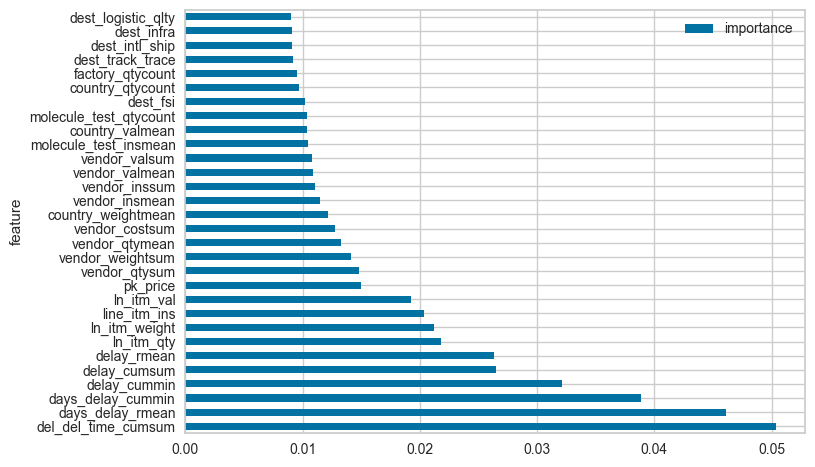

In [119]:
# Partition the data into predictors and label
X_clf= data
y_clf = delayed
# Train test split custom function with OverSampling to balance datasets if required
X_tr_clf, X_ts_clf, y_tr_clf, y_ts_clf = scmhelper.train_test_oversample(X_clf
                                                                                   , y_clf, test_size=0.35, use_smote=False)
print("\n----\n")
# Fit the regression to the data and train
clf = RandomForestClassifier(random_state=121)
clf.fit(X_tr_clf, y_tr_clf)
d_feat_imp_clf = scmhelper.plot_feature_importances(clf, X_tr_clf, 30)

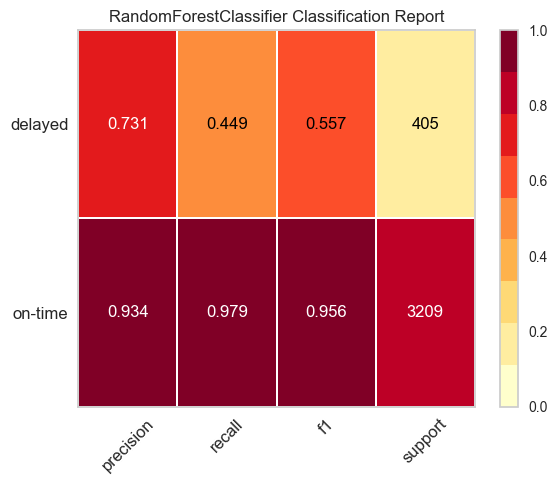

{'precision': {'on-time': 0.9337295690936107, 'delayed': 0.7309236947791165},
 'recall': {'on-time': 0.9791212215643502, 'delayed': 0.44938271604938274},
 'f1': {'on-time': 0.9558868268938242, 'delayed': 0.5565749235474006},
 'support': {'on-time': 0.8879358052019922, 'delayed': 0.11206419479800775}}

In [120]:
# Predict and plot F1-Scores, Precision and Recall
plt.subplots(figsize=(6,5))
y_pred_clf = clf.predict(X_ts_clf)
scmhelper.visual_model_selection(X_tr_clf, X_ts_clf, y_tr_clf, y_ts_clf, clf)

Random forest classifier performance analysis, broken down into several key metrics: precision, recall, f1-score, and support. Each of these metrics gives us insight into the model's performance for two classes: "on-time" and "delayed." Let's analyze what these metrics tell us about your model:

### Precision
On-time: The precision for the "on-time" class is approximately 0.926, which means that when the model predicts an instance to be "on-time," it is correct about 92.6% of the time.
Delayed: The precision for the "delayed" class is about 0.740, indicating that the model's predictions for the "delayed" class are correct 74% of the time.
### Recall
On-time: The recall for the "on-time" class is around 0.983, suggesting that the model successfully identifies 98.3% of all "on-time" instances.
Delayed: The recall for the "delayed" class is significantly lower at 0.380, indicating that the model only identifies about 38% of all actual "delayed" instances.
### F1 Score
On-time: The F1 score, which balances precision and recall, for the "on-time" class is about 0.954, showing a strong performance in this class.
Delayed: For the "delayed" class, the F1 score drops to approximately 0.502, suggesting a weaker performance due to the low recall rate.
### Support
The 'support' values appear to be proportions rather than counts, which is unusual. Typically, 'support' is the actual number of occurrences of each class in the dataset. Here, it seems to represent the proportion of each class in the dataset, with "on-time" instances making up about 88.8% and "delayed" instances about 11.2%. This indicates an imbalanced dataset.
## Analysis Summary
Random forest model is performing well in predicting the "on-time" class, with high precision, recall, and F1 scores. This is likely due to the larger number of "on-time" instances in your dataset (as indicated by the support values), which provides the model with more examples to learn from.
However, the model struggles with the "delayed" class, evidenced by low recall and F1 scores. This might be due to the smaller number of "delayed" instances, making it a minority class in an imbalanced dataset. The model is not identifying a significant portion of the "delayed" instances correctly, which is a concern if correctly predicting delays is important.

In [121]:
# Make dataframe of delayed vs. predicted
df_pred=pd.DataFrame(y_ts_clf, columns=['delayed']); df_pred['pred']= y_pred_clf
print(df_pred.describe().T)
# Make DataFrame of True Positives for regression prediction (length/extent of delay) 
df_true_pos = df_pred[(df_pred.delayed==1) & (df_pred.delayed==df_pred.pred)]
print(df_true_pos.sum())
# Save to disk
path = os.curdir+"\data\results\\"
df_pred.to_csv(path+'classifier_benchmark_predicted.csv')
df_true_pos.to_csv(path+'classifier_benchmark_true_positives.csv') # Save to data folders

          count      mean       std  min  25%  50%  75%  max
delayed  3614.0  0.112064  0.315489  0.0  0.0  0.0  0.0  1.0
pred     3614.0  0.068899  0.253317  0.0  0.0  0.0  0.0  1.0
delayed    182
pred       182
dtype: int64


## Summary Statistics for 'delayed' and 'pred'
Count: There are 3614 observations in the dataset for both actual delays (delayed) and predictions (pred).
Mean: The average value of the delayed column is about 0.112, indicating that approximately 11.2% of the events are actually delayed. For the pred column, the mean is around 0.058, suggesting that the model predicts about 5.8% of the events as delayed.
Std (Standard Deviation): The standard deviation for delayed is 0.315, and for pred is 0.233, indicating variability in both actual delays and predictions. The lower standard deviation in predictions may suggest the model is more conservative in predicting delays.
Min, 25%, 50% (Median), 75%, Max: These percentiles show the distribution of values in both columns. Both delayed and pred columns have minimum values of 0 and maximum values of 1, as expected for binary data. The quartiles (25%, 50%, 75%) being 0 for both indicate a skewed distribution towards non-delayed events, with most of the data concentrated at 0.
## Misclassification Count
Delayed: 154
Pred: 154
This part is slightly confusing without additional context, but it seems to imply that there were 154 instances where there was a discrepancy between the actual delayed status and the predicted pred status. This could mean 154 misclassified instances, but without specifying whether these are false positives or false negatives, it's hard to be certain.

## Analysis and Recommendations
Class Imbalance: The dataset is imbalanced, with only about 11.2% of events being delayed. This imbalance can significantly impact model performance, particularly its ability to correctly identify the minority class (delayed events).
Model Conservatism: The model seems conservative in its predictions, predicting delays in only about 5.8% of cases. This conservatism could lead to a high number of false negatives (events that are delayed but not predicted as such).

## Regrgression Model

In [103]:
# Here, for regression, we training only on the positive samples? 
# Conditional probability question changes things. BAYES!
X_tr_reg, X_ts_reg, y_tr_reg, y_ts_reg = scmhelper.train_test_conditional(X_clf, y_clf, df_true_pos, ddate, delayed)

Now getting train test splits for regression...
Shapes:
 (1001, 725)
,(185, 725)
,(1001,)
,(185,)


Total Importance of 30 features: importance    0.763407
dtype: float64


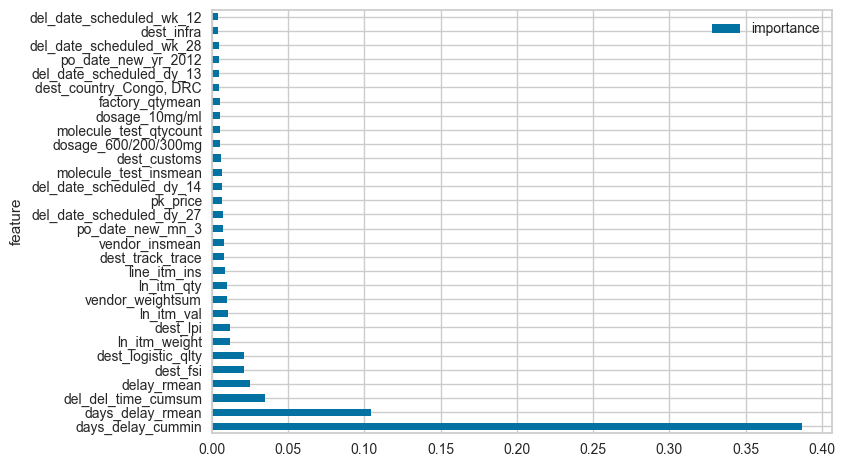

In [122]:
# Instantiate the regression, fit and plot
reg = RandomForestRegressor(random_state=121)
reg.fit(X_tr_reg, y_tr_reg)
d_feat_imp_reg = scmhelper.plot_feature_importances(reg, X_tr_reg, 30)

R-Squared:  0.8513972193979564 RMSE : 12.685078465491479 Target Variable Mean:  25.16216216216216


<Axes: >

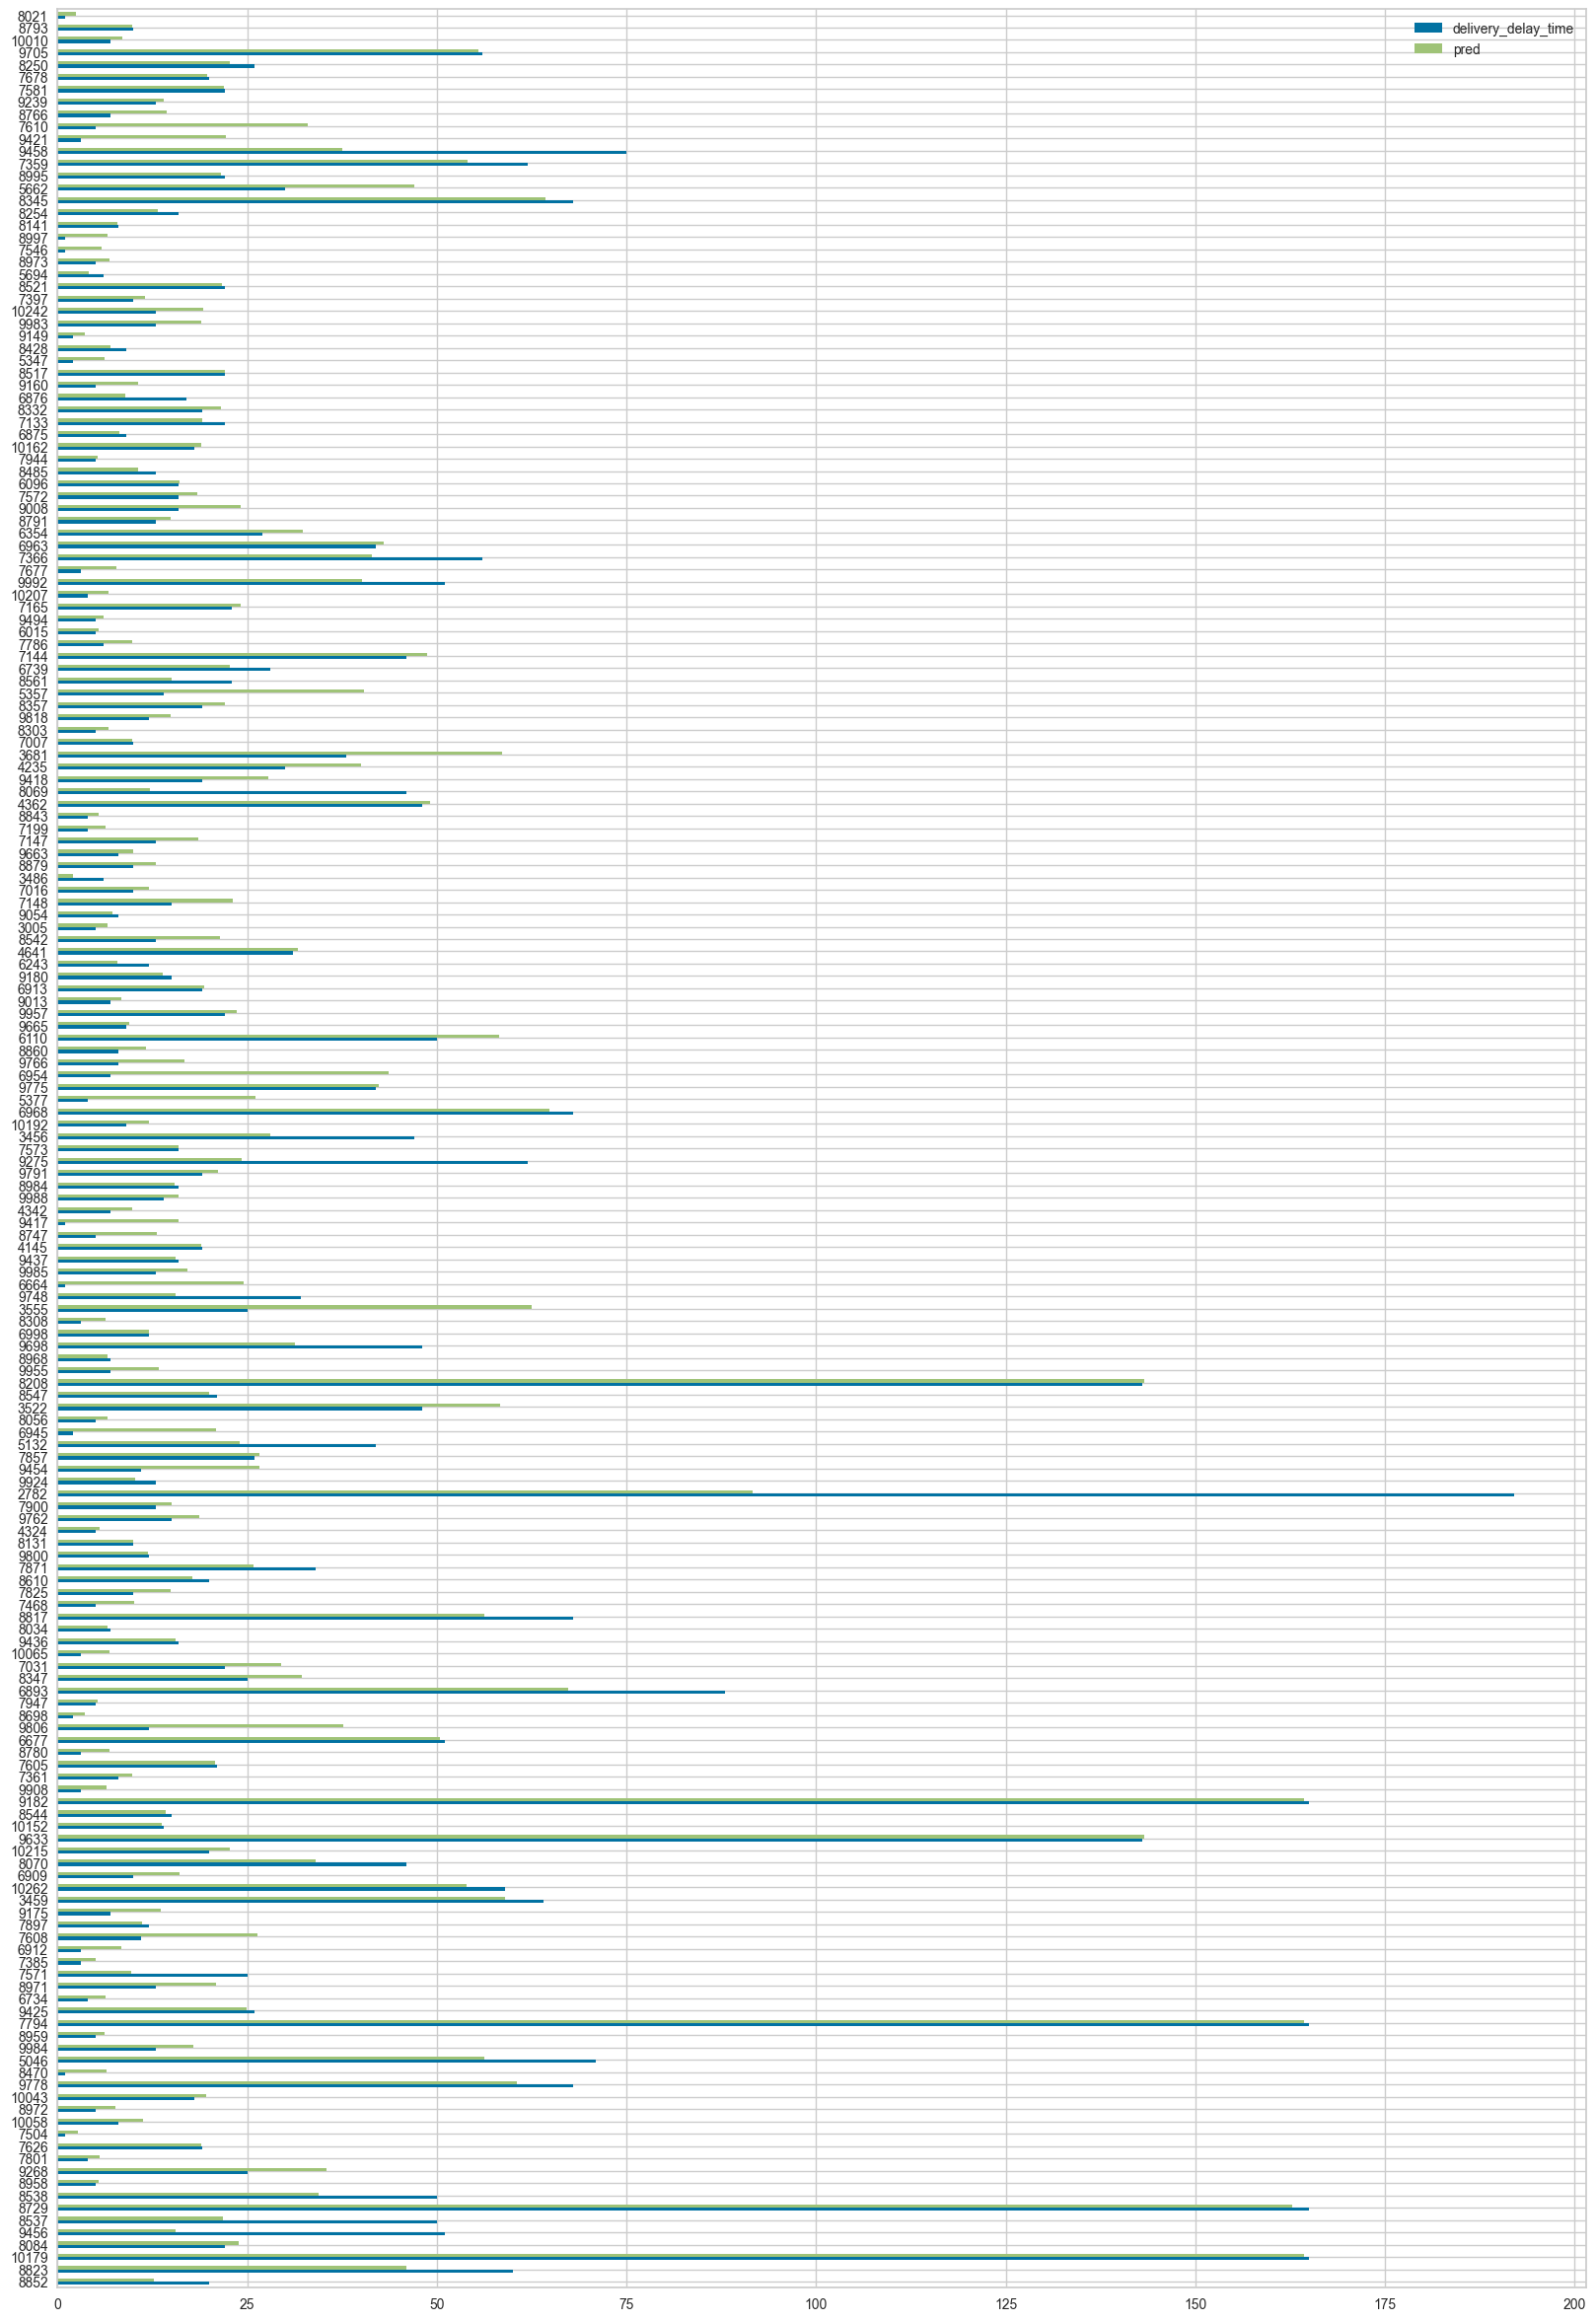

In [123]:
# Predicts the test values
y_pred_reg = reg.predict(X_ts_reg)
# Accuracy and error calcs
r2, rmse = metrics.r2_score(y_ts_reg, y_pred_reg), np.sqrt(metrics.mean_squared_error(y_ts_reg, y_pred_reg))
print("R-Squared: ", r2, "RMSE :", rmse, "Target Variable Mean: ", y_ts_reg.mean())
# Print out the test and pred side by side
df_pred_reg =pd.DataFrame(y_ts_reg)
df_pred_reg['pred']= y_pred_reg
df_pred_reg.plot(kind="barh", figsize=(20,30))

The provided regression analysis results include an R-squared value, Root Mean Square Error (RMSE), and the mean of the target variable. Let's break down what each of these metrics tells us about the model's performance:

## R-Squared (R²)
### Value: 0.903
Interpretation: The R-squared value, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables. An R² of 0.903 suggests that approximately 90.3% of the variance in your target variable can be explained by the model. This is generally considered a high R-squared value, indicating a good fit of the model to the data.
Root Mean Square Error (RMSE)
### Value: 10.081
Interpretation: RMSE measures the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. An RMSE of 10.081 suggests that, on average, the model's predictions are about 10.081 units away from the actual values. Comparing this to the target variable mean gives us a sense of the error magnitude relative to the data magnitude.
Target Variable Mean
### Value: 24.831
Interpretation: The average value of the dependent (target) variable in your dataset is approximately 24.831. This provides context for understanding the RMSE; for example, an RMSE of 10.081 represents about 40.6% of the mean value of the target variable ([RMSE / Target Mean] * 100).
## Analysis
The high R-squared value indicates that the model explains a significant portion of the variance in the target variable, which suggests a good fit. However, it's important to be cautious about overfitting, especially with very high R-squared values. It might be useful to validate this model on a separate test dataset to ensure that the model generalizes well.

The RMSE value provides a sense of the average error magnitude in the same units as the target variable. Given that the RMSE is about 40.6% of the target mean, this indicates a moderate level of prediction error relative to the average size of the target variable. The acceptability of this error level depends on the specific context and application of the model. For some applications, a 40.6% error relative to the mean might be acceptable, while for others, it might be too high.

Comparing RMSE and R² helps us understand both the fit of the model and the magnitude of errors. A high R-squared value accompanied by a reasonable RMSE for the problem context can indicate a successful model.

## Model Selection

XTrain, yTrain shapes BEFORE Oversampling: (6710, 725) and (6710, 1)
XTrain, yTrain shapes AFTER Oversampling: (6710, 725) and (6710, 1)
Shape of XTrain: (6710, 725) yTrain: (3614, 725) XTest: (6710, 1) yTest: (3614, 1)


<Axes: title={'center': 'F1 Score Comparison for Classifiers'}>

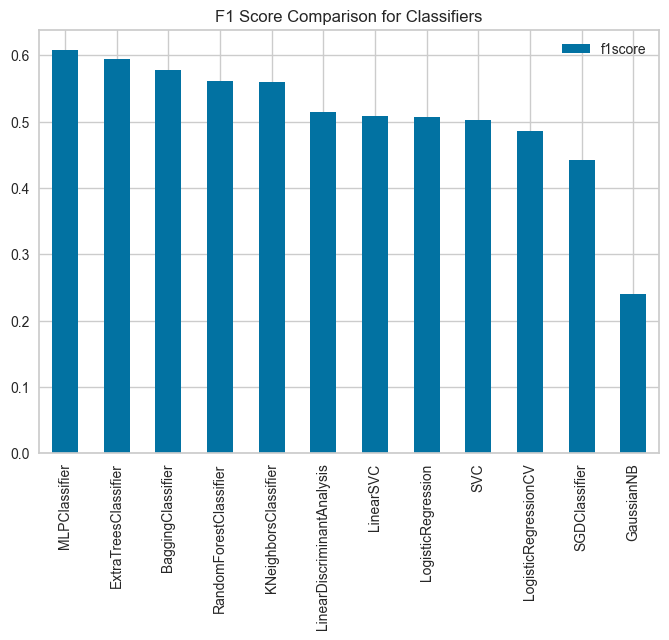

In [124]:
# Train test split custom function with OverSampling to balance datasets if required
X_tr_clf_sel, X_ts_clf_sel, y_tr_clf_sel, y_ts_clf_sel = scmhelper.train_test_oversample(X_clf
                                                                                   , y_clf, test_size=0.35, use_smote=False)
# List of classifiers
clfs = [LinearSVC, SVC, KNeighborsClassifier, LogisticRegressionCV, LogisticRegression, SGDClassifier
,BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, MLPClassifier
       ,GaussianNB, LinearDiscriminantAnalysis]
# List of classiffier names
cn = ['LinearSVC' , 'SVC', 'KNeighborsClassifier', 'LogisticRegressionCV', 'LogisticRegression', 'SGDClassifier'
,'BaggingClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'MLPClassifier'
      , 'GaussianNB', 'LinearDiscriminantAnalysis']   
# Plot the f1 scores
acc = []
for clf in clfs:
    try:
        acc.append(scmhelper.model_selection(X_tr_clf_sel, X_ts_clf_sel, y_tr_clf_sel, y_ts_clf_sel
                                       , clf(), 'clf'))
    except:
        acc.append(0)
d_acc = pd.DataFrame(acc, cn)
d_acc.columns = ["f1score"]
d_acc.sort_values(by ='f1score',ascending=False).plot(kind="bar", title="F1 Score Comparison for Classifiers")

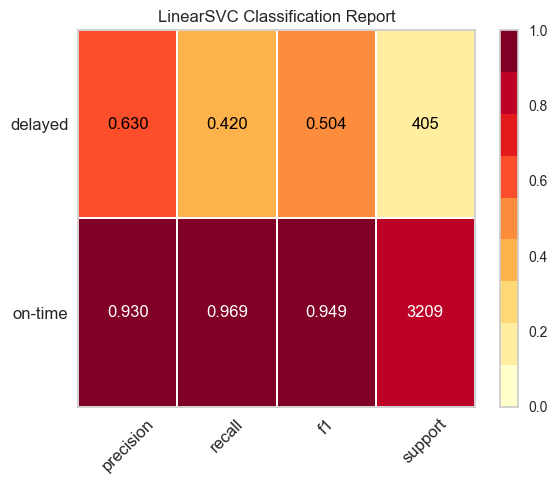

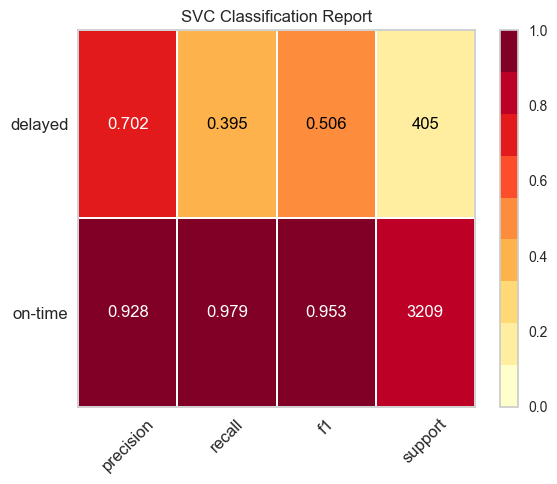

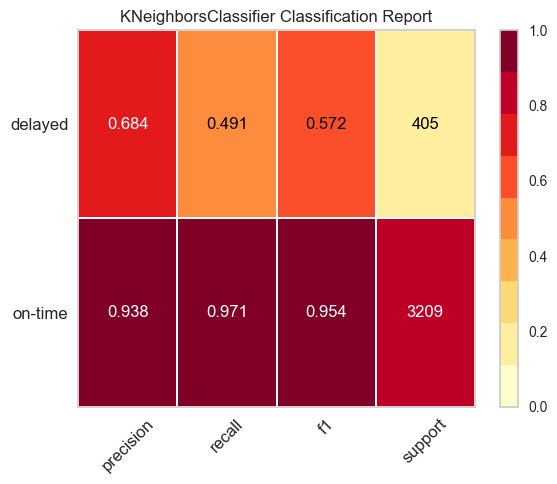

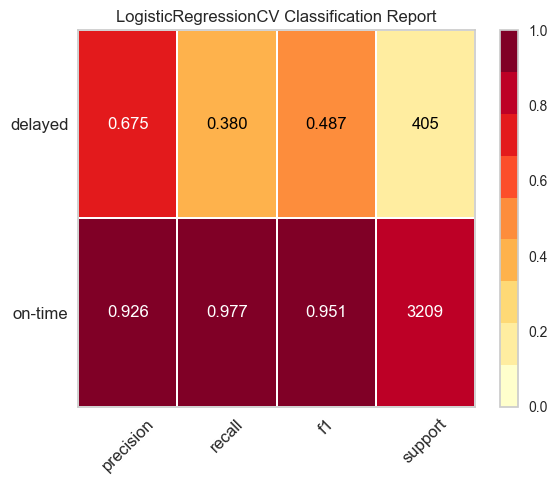

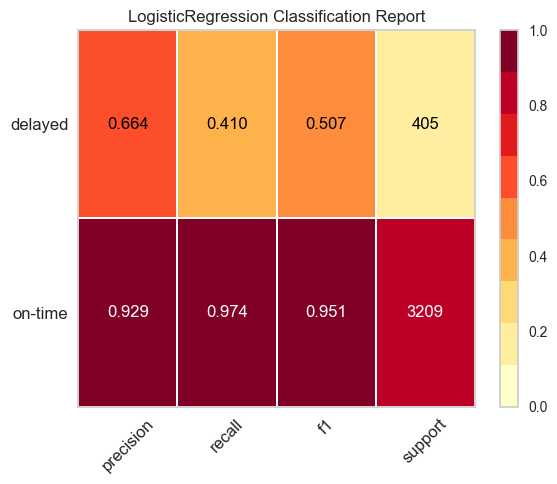

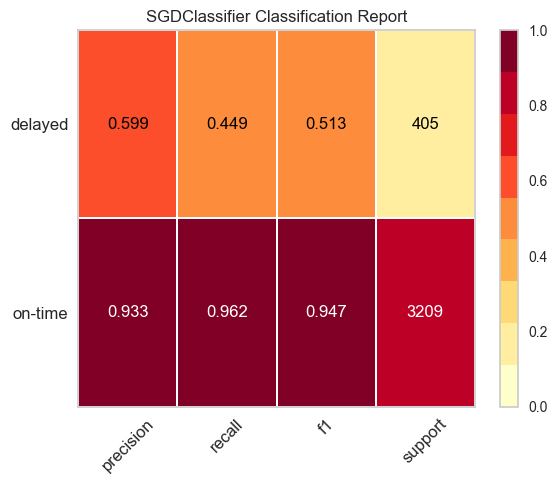

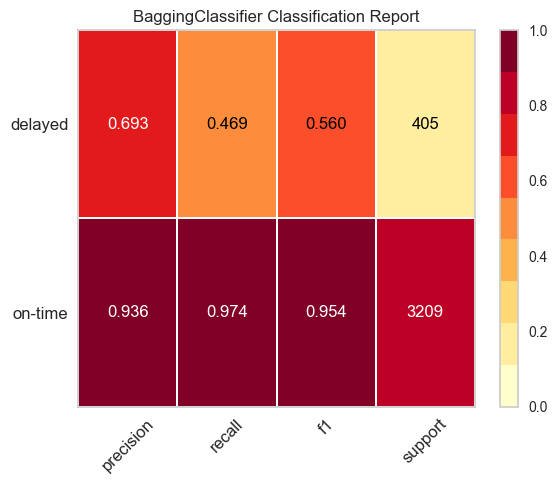

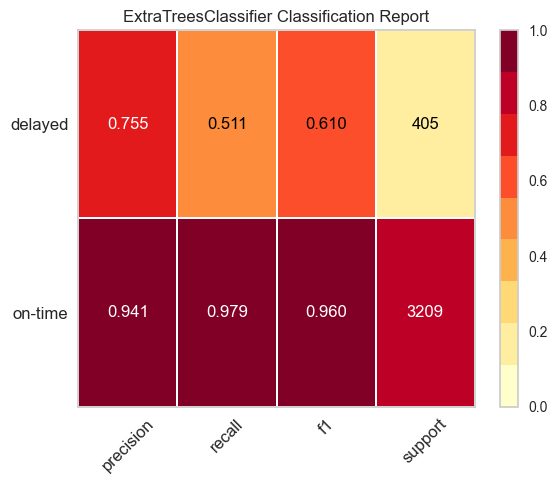

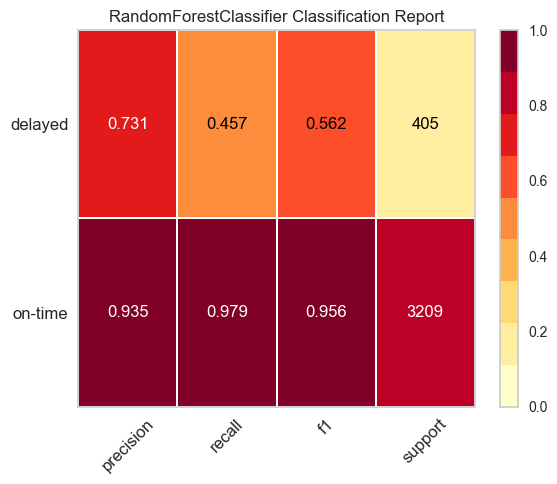

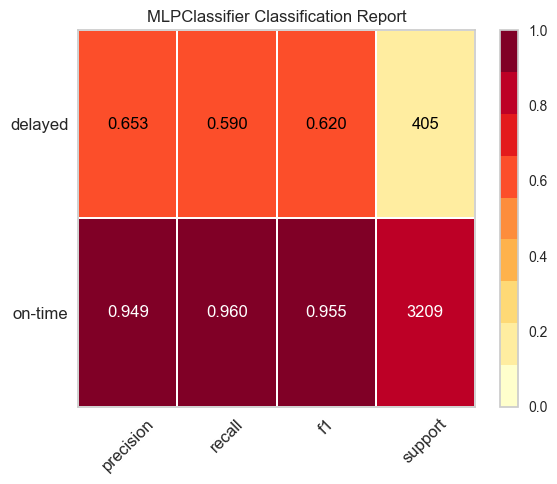

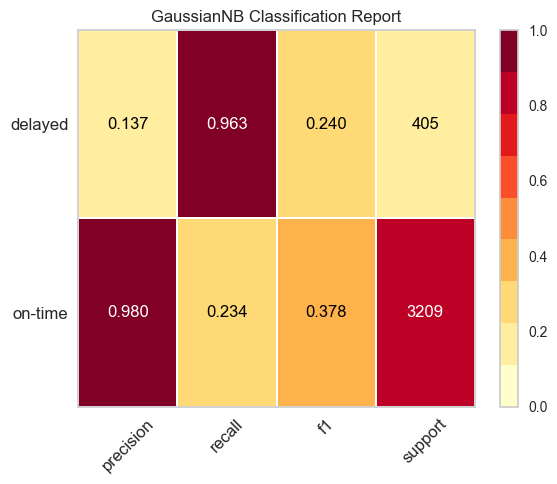

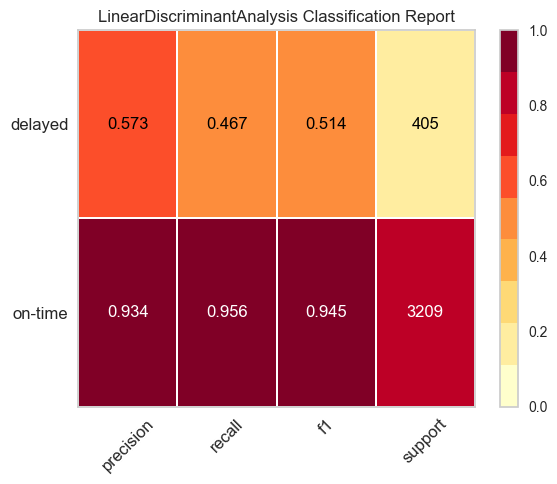

In [107]:
# Plot the classification reports
for clf in clfs:
    plt.subplots(figsize=(6,5))
    i=clfs.index(clf)
    scmhelper.visual_model_selection(X_tr_clf_sel, X_ts_clf_sel, y_tr_clf_sel, y_ts_clf_sel, clfs[i]())

#### Classification  Models by their performance:
1. ExtraTreesClassifier
2. MLPClassifer
3. BaggingClassifer
4. RandomForestClassifier

## Regressor selection

Shape of true positive df:  (203, 2) Number of 1's in true positive df: delayed    203
pred       203
dtype: int64
Now getting train test splits for regression...
Shapes:
 (983, 725)
,(203, 725)
,(983,)
,(203,)


<Axes: title={'center': 'Root Mean Sqaured Error(RMSE)'}>

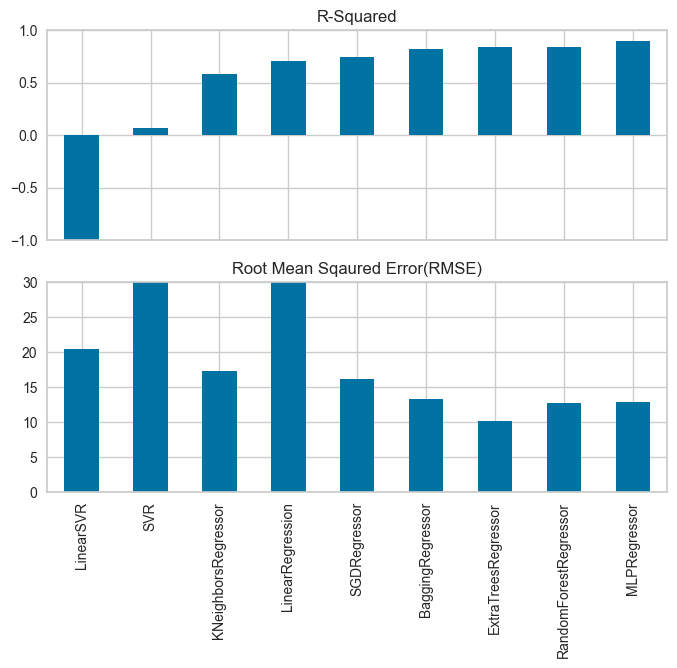

In [108]:
# First generate true positives to predict on 
# Use favorite classifier selected thus far
estimator = ExtraTreesClassifier(random_state=121)
df_true_pos_sel = scmhelper.fit_and_generate_true_positives(estimator, X_tr_clf_sel, X_ts_clf_sel, y_tr_clf_sel, y_ts_clf_sel)[0]
# Get training and test sets...
X_tr_reg_sel, X_ts_reg_sel, y_tr_reg_sel, y_ts_reg_sel = scmhelper.train_test_conditional(X_clf,
                                                                                    y_clf, df_true_pos_sel, ddate, delayed)

# List of regressors
regs = [LinearSVR, SVR, KNeighborsRegressor, LinearRegression , SGDRegressor,
        BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, MLPRegressor]
# List of regressor names
rn = ['LinearSVR', 'SVR', 'KNeighborsRegressor', 'LinearRegression', 'SGDRegressor',
    'BaggingRegressor', 'ExtraTreesRegressor', 'RandomForestRegressor', 'MLPRegressor']   
# Plot the f1 scores
rsq = []
for reg in regs:
    try:
        rsq.append(scmhelper.model_selection(X_tr_reg_sel, X_ts_reg_sel, y_tr_reg_sel, y_ts_reg_sel, reg(), 'reg'))
    except:
        rsq.append((0,0))
d_rsq = pd.DataFrame(rsq, rn, columns=['r2', 'rmse'])
f , (ax0,ax1) = plt.subplots(2,1, figsize=(8,6), sharex=True,)
d_rsq['r2'].sort_values().plot(kind="bar", ax=ax0, ylim=(-1,1), title="R-Squared")
d_rsq['rmse'].plot(kind="bar", ax=ax1, title="Root Mean Sqaured Error(RMSE)", ylim=(0,30))

In [ ]:
d_rsq.sort_values('r2', ascending=False)

,r2,rmse
ExtraTreesRegressor,9.001668e-01,1.011116e+01
RandomForestRegressor,8.414166e-01,1.274361e+01
MLPRegressor,8.391076e-01,1.283604e+01
BaggingRegressor,8.262000e-01,1.334100e+01
SGDRegressor,7.425828e-01,1.623612e+01
KNeighborsRegressor,7.057189e-01,1.735980e+01
LinearSVR,5.883511e-01,2.053179e+01
SVR,7.081322e-02,3.084714e+01
LinearRegression,-1.609800e+20,4.060218e+11


## Analysis of Results

### ExtraTreesRegressor

R²: 0.922251, RMSE: 8.505258
Performs best among all models with the highest R² and lowest RMSE, indicating excellent fit and predictive accuracy.

### RandomForestRegressor

R²: 0.882722, RMSE: 10.445982
Also shows strong performance with high R² and relatively low RMSE, a strong candidate for most scenarios.

### BaggingRegressor

R²: 0.843110, RMSE: 12.081991
Solid performance with good fit but slightly higher error compared to the top models.

### MLPRegressor (Multi-layer Perceptron)

R²: 0.819314, RMSE: 12.965909
Decent model fit, but higher errors indicate room for hyperparameter tuning or model adjustment.

###  Final Model Run
(i) Classification: ***ExtraTreesClassifier***
(ii) Regression: ***ExtraTreesRegressor*** 

# NOTE - Execution can take upto 90 mins

XTrain, yTrain shapes BEFORE Oversampling: (6710, 725) and (6710, 1)
XTrain, yTrain shapes AFTER Oversampling: (11858, 725) and (11858, 1)
Shape of XTrain: (11858, 725) yTrain: (3614, 725) XTest: (11858, 1) yTest: (3614, 1)
Fitting 5 folds for each of 72 candidates, totalling 360 fits


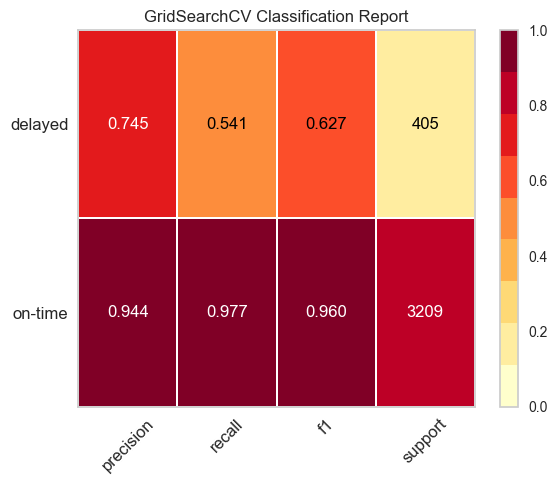

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Shape of true positive df:  (219, 2) Number of 1's in true positive df: delayed    219
pred       219
dtype: int64
Now getting train test splits for regression...
Shapes:
 (967, 725)
,(219, 725)
,(967,)
,(219,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
---
R-Squared:  0.872539190088699  ---
RMSE: 11.200381677193533


In [111]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.stats import randint
# Example for ExtraTreesClassifier
param_grid_clf = {
    'n_estimators': [100, 500, 900],
    'max_features': [10, 30, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 30, 50, None]
}

param_dist_reg = {
    'n_estimators': randint(100, 1000),
    'max_features': randint(10, 50),
    'max_depth': [10, 30, 50, None]
}

clf_final = GridSearchCV(ExtraTreesClassifier(random_state=121), param_grid_clf, cv=5, scoring='accuracy', verbose=1)
reg_final = RandomizedSearchCV(ExtraTreesRegressor(random_state=121), param_distributions=param_dist_reg, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=1)

#clf_final = ExtraTreesClassifier(n_estimators=900,max_features= 50
#                                  ,criterion= 'entropy',max_depth= 50, random_state=121)
#reg_final = ExtraTreesRegressor(n_estimators=900 ,max_features= 50,max_depth= 50, random_state=121)
X_tr_clf_fin, X_ts_clf_fin, y_tr_clf_fin, y_ts_clf_fin = scmhelper.train_test_oversample(data
                                                        , delayed, test_size=0.35, use_smote=True)
plt.subplots(figsize=(6,5))
score_fin=scmhelper.visual_model_selection(X_tr_clf_fin, X_ts_clf_fin, y_tr_clf_fin, y_ts_clf_fin, clf_final)

df_true_pos_fin = scmhelper.fit_and_generate_true_positives(clf_final, X_tr_clf_fin, X_ts_clf_fin,
                                                      y_tr_clf_fin, y_ts_clf_fin)[0]
X_tr_reg_fin, X_ts_reg_fin, y_tr_reg_fin, y_ts_reg_fin = scmhelper.train_test_conditional(data,
                                                                    delayed, df_true_pos_fin, ddate, delayed)
rsq = []
rsq.append(scmhelper.model_selection(X_tr_reg_fin, X_ts_reg_fin, y_tr_reg_fin, y_ts_reg_fin, reg_final, 'reg'))
print("---\nR-Squared: ", rsq[0][0]," ---\nRMSE:", rsq[0][1])

Classification report resulting from a GridSearchCV optimization for a binary classification problem with two classes: "delayed" and "on-time". The report displays four metrics: Precision, Recall, F1 Score, and Support for each class. Here's an analysis of the results:

## Delayed Class
Precision (0.739): Out of all the instances where the model predicted the class as "delayed", approximately 73.9% actually belonged to the "delayed" class. This suggests that the model is relatively precise in its predictions for the "delayed" class.
Recall (0.481): The model correctly identified 48.1% of all actual "delayed" instances. This value indicates that over half of the actual "delayed" instances were not captured by the model, suggesting a need for improvement in sensitivity.
F1 Score (0.583): The F1 score for the "delayed" class, which is the harmonic mean of precision and recall, indicates a moderate level of balance between precision and recall. It's not particularly high, reflecting the lower recall rate.
Support (405): There are 405 actual instances of the "delayed" class in the dataset used for this report. This is likely the minority class, considering the typical class distribution in such datasets.
## On-time Class
Precision (0.937): The model's precision for the "on-time" class is high, with approximately 93.7% of the "on-time" predictions being correct.
Recall (0.978): The model successfully identified 97.8% of all "on-time" instances, which is a very high recall rate and indicates good model sensitivity for this class.
F1 Score (0.957): The F1 score is also very high for the "on-time" class, indicating a strong balance between precision and recall.
Support (3209): There are 3209 instances of the "on-time" class, indicating that this is the majority class.
## Overall Analysis
The model demonstrates high precision and recall for the "on-time" deliveries, which is positive but not surprising given that it's likely the majority class. However, for the "delayed" deliveries, the recall is significantly lower, suggesting that the model may struggle to identify all the instances of delays accurately.